In [0]:
%python
# Setting the bucket name in Spark configuration
bucket_name = 'voc-75-databricks-data'
spark.conf.set("spark.databricks.TWEET_BUCKET_NAME", bucket_name)


## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:


%run ./includes/includes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.4 requires pyspark>=2.1.0, which is not installed.


In [0]:


%run ./includes/utilities




VERY IMPORTANT TO UNDERSTAND THE USE OF THESE VARIABLES! Please ask if you are confused about their use. 
 
 Variable Name Value Description 
 TWEET_BUCKET_NAME voc-75-databricks-data AWS S3 Bucket Name where the tweets are coming into your system. 
 TWEET_BUCKET_URL https://voc-75-databricks-data.s3.amazonaws.com/ AWS S3 Bucket URL where the tweets are coming into your system. 
 TWEET_SOURCE_PATH s3a://voc-75-databricks-data/voc_volume/ AWS S3 Path where the tweets are coming into your system. 
 USER_DIR /tmp/labuser104917-3128913/ Path to the local storage (dbfs) for your project. 
 BRONZE_CHECKPOINT /tmp/labuser104917-3128913/bronze.checkpoint Store your Bronze Checkpoint data here. 
 BRONZE_DELTA /tmp/labuser104917-3128913/bronze.delta Store your Bronze Delta Table here. 
 SILVER_CHECKPOINT /tmp/labuser104917-3128913/silver.checkpoint Store your Silver Checkpoint data here. 
 SILVER_DELTA /tmp/labuser104917-3128913/silver.delta Store your Silver Delta Table here. 
 GOLD_CHECKPOINT /tmp/labuser104917-3128913/gold.checkpoint Store your Gold Checkpoint data here. 
 GOLD_DELTA /tmp/labuser104917-3128913/gold.delta Store your Gold Delta Table here. 
 MODEL_NAME HF_TWEET_SENTIMENT Load this production model 
 HF_MODEL_NAME finiteautomata/bertweet-base-sentiment-analysis The Hugging Face Model for Tweet sentiment classification: https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis

the includes are included


In [0]:
%python
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

Test space


IMPORTING LIBRARIES


SECTION 3

EDA

STEP 5 SILVER DATA

gold processsing

############ NEW ATTEMPT


#####Viewwing gold delta

# FULL_DATASET

## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:



%run ./includes/utilities
%run ./includes/includes



In [0]:

# PySpark and Spark Streaming
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
import numpy as np
# Delta Lake for managing and versioning big data
from delta import *
from pyspark.sql.functions import col, count, isnan, when
# MLflow for managing the ML lifecycle
import mlflow
import mlflow.pyfunc
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from pyspark.sql.functions import col, isnan, when, lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col, to_timestamp, expr
from pyspark.sql.functions import col, to_timestamp, explode_outer, regexp_replace, split, expr
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
# Libraries for data manipulation and transformation
from pyspark.sql.functions import col, from_json, explode
from pyspark.sql.types import StringType, StructField, StructType

# Pretrained transformer model for sentiment analysis
from transformers import pipeline

# Utility libraries for data handling
import json

# Visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

# Setting Spark SQL shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", "200")  # Adjust based on your cluster's cores and data size
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from mlflow import *
import mlflow.pyfunc
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os
from pyspark.sql.streaming import StreamingQuery
from pyspark.sql.functions import input_file_name, current_timestamp

## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
%run ./includes/includes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.4 requires pyspark>=2.1.0, which is not installed.


In [0]:
%run ./includes/utilities
%run ./includes/includes


In [0]:


# ENTER YOUR CODE HERE
# Assuming the function get_source_listing_df and the TWEET_BUCKET_NAME variable are already defined

file_listing_df = get_source_listing_df()
print(file_listing_df)



                    File Name
0           voc_volume/0.json
1           voc_volume/1.json
2          voc_volume/10.json
3         voc_volume/100.json
4        voc_volume/1000.json
...                       ...
199996  voc_volume/99995.json
199997  voc_volume/99996.json
199998  voc_volume/99997.json
199999  voc_volume/99998.json
200000  voc_volume/99999.json

[200001 rows x 1 columns]


VERY IMPORTANT TO UNDERSTAND THE USE OF THESE VARIABLES! Please ask if you are confused about their use. 
 
 Variable Name Value Description 
 TWEET_BUCKET_NAME voc-75-databricks-data AWS S3 Bucket Name where the tweets are coming into your system. 
 TWEET_BUCKET_URL https://voc-75-databricks-data.s3.amazonaws.com/ AWS S3 Bucket URL where the tweets are coming into your system. 
 TWEET_SOURCE_PATH s3a://voc-75-databricks-data/voc_volume/ AWS S3 Path where the tweets are coming into your system. 
 USER_DIR /tmp/labuser104917-3128913/ Path to the local storage (dbfs) for your project. 
 BRONZE_CHECKPOINT /tmp/labuser104917-3128913/bronze.checkpoint Store your Bronze Checkpoint data here. 
 BRONZE_DELTA /tmp/labuser104917-3128913/bronze.delta Store your Bronze Delta Table here. 
 SILVER_CHECKPOINT /tmp/labuser104917-3128913/silver.checkpoint Store your Silver Checkpoint data here. 
 SILVER_DELTA /tmp/labuser104917-3128913/silver.delta Store your Silver Delta Table here. 
 GOLD_CHECKPOINT /tmp/labuser104917-3128913/gold.checkpoint Store your Gold Checkpoint data here. 
 GOLD_DELTA /tmp/labuser104917-3128913/gold.delta Store your Gold Delta Table here. 
 MODEL_NAME HF_TWEET_SENTIMENT Load this production model 
 HF_MODEL_NAME finiteautomata/bertweet-base-sentiment-analysis The Hugging Face Model for Tweet sentiment classification: https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis

the includes are included


In [0]:


print(len(file_listing_df))

200001


In [0]:

first_file_name = file_listing_df.iloc[0]['File Name']  # This gets the filename of the first row
file_contents = show_s3_file_contents(first_file_name)
print(file_contents)

b'{"date": "Mon Apr 06 22:19:45 PDT 2009", "user": "_TheSpecialOne_", "text": "@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "sentiment": "negative"}'


## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:


# ENTER YOUR CODE HERE
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

# Define the schema for the incoming JSON data
bronze_schema = StructType([
    StructField("date", StringType(), True),  # Assuming dates are in string format; consider converting to date type later
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("source_file", StringType(), True),
    StructField("processing_time", TimestampType(), True)  # Automatically capture the processing timestamp
])


In [0]:

# Correcting the Spark configuration setting
spark.conf.set("spark.databricks.TWEET_BUCKET_NAME", "voc-75-databricks-data")


In [0]:

######### PRIMARY CODE
from pyspark.sql.functions import input_file_name, current_timestamp

# Initialize the Spark session
spark = SparkSession.builder \
    .appName("Tweet Sentiment Analysis") \
    .getOrCreate()

# Set the location of the JSON files on cloud storage
#input_path = "s3a://<your-bucket-name>/<path-to-json-files>"

# Read the stream with CloudFiles
raw_stream_df = (spark.readStream
                 .format("cloudFiles")
                 .option("cloudFiles.format", "json")
                 .schema(bronze_schema)  # Use the schema defined previously
                 .load("s3a://voc-75-databricks-data/voc_volume")
                 .withColumn("source_file", input_file_name())
                 .withColumn("processing_time", current_timestamp()))

# Define the output path for the Delta table
####output_path = "dbfs:/path/to/bronze/delta/table"
####checkpoint_path = "dbfs:/path/to/checkpoints/bronze"

# Write the data stream to a Delta table in append mode
bronze_stream_query = (raw_stream_df.writeStream
                       .format("delta")
                       .outputMode("append")
                       .option("checkpointLocation", BRONZE_CHECKPOINT)
                       .option("mergeSchema", "true")
                       .queryName("bronze_stream")
                       .start(BRONZE_DELTA))



## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:

# ENTER YOUR CODE HERE
# Read the Bronze Delta table into a DataFrame
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)
# Count the number of tweets
tweet_count = bronze_df.count()
print(tweet_count)





200000


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
<command-1599202439920183> in <cell line: 1>()
----> 1 bronze_df.show()

/databricks/spark/python/pyspark/instrumentation_utils.py in wrapper(*args, **kwargs)
     46             start = time.perf_counter()
     47             try:
---> 48                 res = func(*args, **kwargs)
     49                 logger.log_success(
     50                     module_name, class_name, function_name, time.perf_counter() - start, signature

/databricks/spark/python/pyspark/sql/dataframe.py in show(self, n, truncate, vertical)
    609 
    610         if isinstance(truncate, bool) and truncate:
--> 611             print(self._jdf.showString(n, 20, vertical))
    612         else:
    613             try:

/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1319 
   1320         answer = self.gateway

In [0]:

############ NEED TO CHANGE "example_numeric_column1and 2"##############

from pyspark.sql.functions import col, count, isnan, when

# List of columns to check for NaN values (only numeric columns)
numeric_cols = ['example_numeric_column1', 'example_numeric_column2']  # Replace with your actual numeric column names

# Check for NaN and null in numeric columns, and only null for other columns
null_and_nan_counts = bronze_df.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) if c in numeric_cols else count(when(col(c).isNull(), c)).alias(c)
     for c in bronze_df.columns]
)
null_and_nan_counts.show()



+----+----+----+---------+-----------+---------------+
|date|user|text|sentiment|source_file|processing_time|
+----+----+----+---------+-----------+---------------+
|   0|   0|   0|        0|          0|              0|
+----+----+----+---------+-----------+---------------+



In [0]:

# Print the schema of the DataFrame
bronze_df.printSchema()


root
 |-- date: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- source_file: string (nullable = true)
 |-- processing_time: timestamp (nullable = true)



In [0]:

from pyspark.sql.functions import col, count, when

# Check for null values in each column
null_counts = bronze_df.select([count(when(col(c).isNull(), c)).alias(c) for c in bronze_df.columns])
null_counts.show()


+----+----+----+---------+-----------+---------------+
|date|user|text|sentiment|source_file|processing_time|
+----+----+----+---------+-----------+---------------+
|   0|   0|   0|        0|          0|              0|
+----+----+----+---------+-----------+---------------+



In [0]:

from pyspark.sql.functions import desc

# Count tweets by user and sort by descending order
tweets_by_user = bronze_df.groupBy("user").count().orderBy(desc("count"))
tweets_by_user.show()


+---------------+-----+
|           user|count|
+---------------+-----+
|       tweetpet|  178|
|     nuttychris|   71|
|  divxdownloads|   68|
|       tsarnick|   47|
|      lesley007|   44|
|    MissxMarisa|   42|
|      Emmmaa___|   38|
|  redrobinrockn|   36|
|   TraceyHewins|   34|
|       tweetles|   34|
|         keza34|   34|
|        kasey79|   31|
|   GabezRosales|   31|
|torilovesbradie|   30|
|        xoCAZZA|   30|
| MiDesfileNegro|   28|
|    violetbakes|   28|
|         Djalfy|   28|
|   dan_ashcroft|   28|
|       clara018|   27|
+---------------+-----+
only showing top 20 rows



In [0]:

from pyspark.sql.functions import col, when, count

# Adding a column to count mentions and then counting how many tweets have mentions
mention_counts = bronze_df.withColumn("has_mention", col("text").contains("@"))
mention_summary = mention_counts.groupBy("has_mention").agg(count(when(col("has_mention"), True)).alias("count"))
mention_summary.show()



+-----------+-----+
|has_mention|count|
+-----------+-----+
|       true|47620|
|      false|    0|
+-----------+-----+



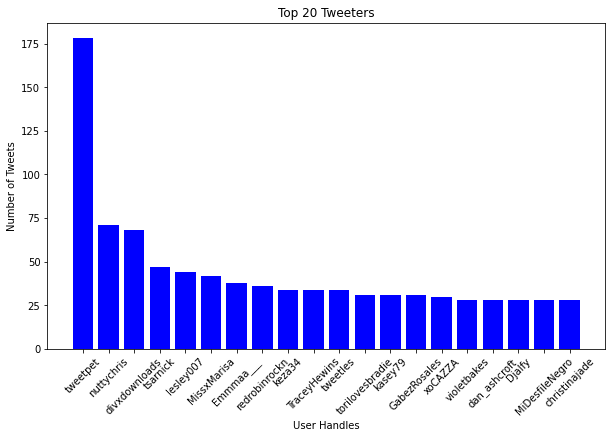

In [0]:


import matplotlib.pyplot as plt
import pandas as pd

# Collect data to Pandas for plotting
top_tweeters = tweets_by_user.limit(20).toPandas()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_tweeters['user'], top_tweeters['count'], color='blue')
plt.xlabel('User Handles')
plt.ylabel('Number of Tweets')
plt.title('Top 20 Tweeters')
plt.xticks(rotation=45)
plt.show()


## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
dbutils.fs.rm(SILVER_DELTA, True)
dbutils.fs.rm(SILVER_CHECKPOINT, True)
# Create the Silver Delta and checkpoint directories again
dbutils.fs.mkdirs(SILVER_DELTA)
dbutils.fs.mkdirs(SILVER_CHECKPOINT)

Out[29]: True

In [0]:
from pyspark.sql.functions import desc
from pyspark.sql.functions import col, to_timestamp, expr
from pyspark.sql.functions import col, to_timestamp, explode_outer, regexp_replace, split, expr
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
# Define the Silver data schema
silver_data_schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("mention", StringType(), True),
    StructField("cleaned_text", StringType(), True),
    StructField("sentiment", StringType(), True)
])



In [0]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [0]:
bronze_df = (
    spark.readStream
    .format("delta")
    .option("path", BRONZE_DELTA)
    .load()
)

In [0]:
#def remove_tz_abbr(date_str):
#    return regexp_replace(date_str, "PDT|PST|EST|CST|UTC", "")

date_format = "EEE MMM dd HH:mm:ss z yyyy"

silver_df = bronze_df.select(
    to_timestamp(col("date"), date_format).alias("timestamp"),
    expr("explode_outer(split(text, ' ')) as word"),
    regexp_replace(col("text"), "@\\w+", "").alias("cleaned_text"),
    col("sentiment")
).where(col("word").rlike("^@\\w+"))

# Transform to have rows for each mention specifically
silver_expanded_df = silver_df.select(
    "timestamp",
    expr("substring(word, 2) as mention"),  # Remove '@' from the mention
    "cleaned_text",
    "sentiment"
)

In [0]:
silver_stream = (
    silver_expanded_df
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", SILVER_CHECKPOINT)
    .start(SILVER_DELTA)
)

In [0]:
silverst_df.count()

Out[12]: 97417

In [0]:
silverst_df = spark.read.format("delta").load(SILVER_DELTA)
silverst_df.show()

+-------------------+---------------+--------------------+---------+
|          timestamp|        mention|        cleaned_text|sentiment|
+-------------------+---------------+--------------------+---------+
|2009-05-02 13:02:40|      TextTonic| &quot;control&qu...| positive|
|2009-05-02 12:42:18|       ddlovato| .ahh, Im scared ...| positive|
|2009-05-02 12:47:06|       hlsidle.|. Did you go on i...| positive|
|2009-05-02 12:42:32|     leehancock|  tempted to make...| positive|
|2009-05-02 12:52:16|      eksentrik| Are you sure? Ga...| positive|
|2009-05-02 12:42:26|      ribzlike)|Just back from #g...| negative|
|2009-05-02 12:42:42|      TheTreelo|  i might be on a...| negative|
|2009-05-02 12:47:44|   Michaela1791| you never know u...| positive|
|2009-05-02 12:57:06|      wiilassie|  I've been watch...| positive|
|2009-05-02 12:57:06|     llordllama|  I've been watch...| positive|
|2009-05-02 12:57:19|    skyhorsepub| Your submission ...| positive|
|2009-05-02 13:02:35|        Djelb

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
model_uri = "models:/HF_TWEET_SENTIMENT/Production"
model = mlflow.pyfunc.spark_udf(spark, model_uri=model_uri)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-7e20f861-4af3-44bc-9292-13e4d5a7f100/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


2024/05/11 23:50:10 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/11 23:50:14 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.12.2, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/11 23:50:14 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/05/11 23:50:15 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:

%sql
OPTIMIZE SILVER_DELTA;

path metrics dbfs:/path/to/user/directory/silver.delta List(0, 0, List(null, null, 0.0, 0, 0), List(null, null, 0.0, 0, 0), 0, null, 0, 0, 0, true, 0, 0, 1715475830810, 1715475831819, 4, 0, null)

In [0]:
sentiment_analysis_udf = mlflow.pyfunc.spark_udf(spark, "models:/HF_TWEET_SENTIMENT/Production")

2024/05/12 01:04:37 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/12 01:04:41 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.12.2, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/12 01:04:41 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/05/12 01:04:41 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:
# Setup a read stream on your silver delta table
silver_df = (
    spark.readStream
    .format("delta")
    .option("ignoreChanges", "true")
    .load(SILVER_DELTA)
)

In [0]:
# Use a spark UDF to parallelize the inference across your silver data
gold_df = silver_df.withColumn("predictions", sentiment_analysis_udf(col("cleaned_text"))) \
    .select(
        col("timestamp"),
        col("mention"),
        col("cleaned_text"),
        col("sentiment"),
        col("predictions.label").alias("predicted_sentiment"),
        col("predictions.score").alias("predicted_score"),
        when(col("sentiment") == "negative", 0).otherwise(1).alias("sentiment_id"),
        when(col("predictions.label") == "NEG", 0)
        .when(col("predictions.label") == "NEU", -1)
        .when(col("predictions.label") == "POS", 1)
        .otherwise(None) 
        .alias("predicted_sentiment_id")
    )

In [0]:
# Setup a write stream to append to the gold delta table
gold_stream = gold_df.writeStream.format("delta").outputMode("append").option("checkpointLocation", GOLD_CHECKPOINT).start(GOLD_DELTA)
     

In [0]:

display(gold_df)

timestamp mention cleaned_text sentiment predicted_sentiment predicted_score sentiment_id predicted_sentiment_id 2009-04-21T06:56:12.000+0000 ImCourtneyNZ That's weird - my first & middle names are Marisa Jo! Haha, so I get called MJ, too. That's where "Mojo" came from positive POS 0.5748512148857117 1 1 2009-04-21T07:00:42.000+0000 mileycyrus you shldnt care what others say so much, you are beautiful <3 and that jst makes ppl jealous. please come to australia soon positive POS 0.9524397253990173 1 1 2009-04-21T07:06:15.000+0000 REMSUH Glad to hear ur on Twtr. Is your caps lock on? Just so u know, typing all caps is the online version of shouting. Gotte be hip positive POS 0.9777770042419434 1 1 2009-04-21T06:46:00.000+0000 rolliev2 yeah. you should've texted me or something to remind me that you were coming back. i would've stayed longer, but i forgot you negative NEU 0.6231721639633179 0 -1 2009-04-07T09:59:13.000+0000 Sheamus Yep done that from the off - just have All Friends | Search | My Tweets panels. Hmm interesting, maybe it will fix itself later negative POS 0.6415472626686096 0 1 2009-04-21T06:56:09.000+0000 liquidwings You are not alone, I often think of suicide on almost a daily basis, but I have to keep going for my family. I want to kill positive NEG 0.8954702019691467 1 0 2009-04-21T07:00:41.000+0000 nicholasbraun i didn't know that you mark 2 of my to you as your favorites.haha.thanks.that means a lot!and also, i love you! positive POS 0.992330014705658 1 1 2009-04-21T07:00:41.000+0000 replies i didn't know that you mark 2 of my to you as your favorites.haha.thanks.that means a lot!and also, i love you! positive POS 0.992330014705658 1 1 2009-04-21T06:51:09.000+0000 XombieXS touche, I know of a great artist, buuut I think he got himself into trouble which sucks think you might go with one of VInces? negative NEG 0.9615314602851868 0 0 2009-04-21T07:11:09.000+0000 Moonpoppy You'll be pleased to hear your better half has now successfully reserved The Blue Room, which is looking great, for Whitsun. positive POS 0.9897094368934631 1 1 2009-04-21T07:00:20.000+0000 TrueGabe Ok let's try again - How are u doing Gabe? Are u having a great eve? We're having a chilly Tue morning here - season's changing positive POS 0.7289852499961853 1 1 2009-04-21T07:00:25.000+0000 officialTila hey tila i actually really kinda love it excited to hear more.and were you trying to seduce me? ..cause it worked lmao jk positive POS 0.9929596781730652 1 1 2009-04-21T07:00:28.000+0000 RealLamarOdom Hi LO, socal is super hot!!!! Good Luck tommorrow!!! You have many female fans on facebook La Lakers Hotties, much love positive POS 0.9929903745651245 1 1 2009-04-21T07:06:21.000+0000 rogeraberg Did you do it witht #CSS_Sprites? I started a couple of weeks ago and they rock, 4 steps, (normal, rollover, click, active positive POS 0.9416298270225525 1 1 2009-04-21T07:10:47.000+0000 failurebydsgn Picnic na lang tayo haha Let us not waste our money on mundane things. With picnic basket and checkered mat dapat ah haha positive POS 0.7429347634315491 1 1 2009-04-21T07:11:07.000+0000 JoelMadden I'm a fan of the new hair...I'm thinking you look all sorts of sexified! Keep on doing what you do, because it's working positive POS 0.9904871582984924 1 1 2009-04-21T06:45:57.000+0000 firstplaceloser yes it is free radio.. sorry for the super delayed reply. just go to www.audio8ball.com there are other shows too! positive POS 0.5948155522346497 1 1 2009-04-21T06:51:01.000+0000 Sophie_Lhoste I mean, blunt as in not afraid to say Taliban vile scum deserve to die, Israel is a Zionazi state, Saudi royals are vile positive NEG 0.979973316192627 1 0 2009-04-21T06:56:00.000+0000 JScottCampbell Hi! Yep it is My ultimate goal is to draw a Harry Potter book, so I'm just drawing it for fun and hoping for the best!! positive POS 0.9910697937011719 1 1 2009-04-21T06:56:08.000+0000 Rocket_Minions I see a little silhouetto of a man, SCARAMOUCHE, SCARAMOUCHE, will you do the fa

## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
from pyspark.sql.functions import col, isnan, when, lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col, to_timestamp, expr
from pyspark.sql.functions import col, to_timestamp, explode_outer, regexp_replace, split, expr
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
# Replace NaN and Inf values in Spark DataFrame
cleaned_df = gold_table_df.withColumn("predicted_sentiment_id", 
                when(isnan(col("predicted_sentiment_id")) | col("predicted_sentiment_id").isNull(), lit(0)) # Replace NaN with 0
                .otherwise(col("predicted_sentiment_id")))

# If there are infinite values, replace them
cleaned_df = cleaned_df.withColumn("predicted_sentiment_id", 
                when(col("predicted_sentiment_id") == float('inf'), lit(1)) # Assuming you want to replace inf with 1
                .otherwise(col("predicted_sentiment_id")))


In [0]:
import numpy as np
gold_df_pd = cleaned_df.toPandas()

# Replace any remaining NaN or infinite values in Pandas DataFrame
gold_df_pd['predicted_sentiment_id'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf/-inf with NaN
gold_df_pd.fillna(0, inplace=True) # Replace NaNs with 0


In [0]:
# Ensure all data is finite
gold_df_pd = gold_df_pd[np.isfinite(gold_df_pd['predicted_sentiment_id'])]

# Check for any remaining extreme values if necessary
print(gold_df_pd['predicted_sentiment_id'].describe())


count    97459.000000
mean         0.477031
std          0.499475
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: predicted_sentiment_id, dtype: float64


In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from pyspark.sql.functions import col, isnan, when, lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col, to_timestamp, expr
from pyspark.sql.functions import col, to_timestamp, explode_outer, regexp_replace, split, expr
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
y_true = gold_df_pd["sentiment_id"]
y_pred = gold_df_pd["predicted_sentiment_id"]

precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)


In [0]:
import numpy as np

# Convert Spark DataFrame to Pandas DataFrame
gold_df_pd = gold_table_df.toPandas()

# Replace any specific values that might be problematic (e.g., -1 for 'Neutral')
gold_df_pd['predicted_sentiment_id'] = gold_df_pd['predicted_sentiment_id'].replace(-1, 1)

# Drop any rows with NaN values in the relevant columns to ensure clean data
gold_df_pd.dropna(subset=['sentiment_id', 'predicted_sentiment_id'], inplace=True)

# Replace infinities if any exist after previous operations
gold_df_pd.replace([np.inf, -np.inf], np.nan, inplace=True)
gold_df_pd.dropna(inplace=True)  # Dropping rows with NaN values which might be created by replacing infinities

# Ensure that all data is of type float64, which is expected by scikit-learn
gold_df_pd['predicted_sentiment_id'] = gold_df_pd['predicted_sentiment_id'].astype('float64')
gold_df_pd['sentiment_id'] = gold_df_pd['sentiment_id'].astype('float64')


In [0]:
# Quick check to ensure no NaN or infinite values remain
assert not gold_df_pd['predicted_sentiment_id'].isnull().any(), "NaNs exist in the predicted_sentiment_id column"
assert not gold_df_pd['sentiment_id'].isnull().any(), "NaNs exist in the sentiment_id column"
assert np.isfinite(gold_df_pd['predicted_sentiment_id']).all(), "Infinite values found in predicted_sentiment_id"
assert np.isfinite(gold_df_pd['sentiment_id']).all(), "Infinite values found in sentiment_id"


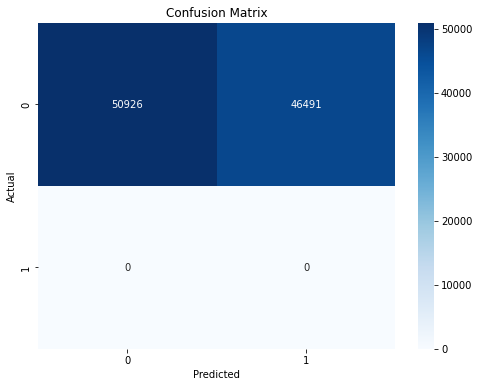

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from pyspark.sql.functions import col, isnan, when, lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col, to_timestamp, expr
from pyspark.sql.functions import col, to_timestamp, explode_outer, regexp_replace, split, expr
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

y_true = gold_df_pd["sentiment_id"]
y_pred = gold_df_pd["predicted_sentiment_id"]

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)

# Start an MLflow run to log metrics, parameters, and artifacts
with mlflow.start_run():
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_param("model_name", "tweets_sentiment_analysis")
    mlflow.log_param("mlflow_version", mlflow.__version__)
    mlflow.log_param("delta_table_version", "2")

    # Plot and save confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")


## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [0]:

# ENTER YOUR CODE HERE
gold_mentions = gold_table_df.select("mention").distinct().count()
print("Number of mentions in the Gold data: ",gold_mentions)

Number of mentions in the Gold data:  65229


In [0]:

# Count the number of neutral, positive and negative tweets for each mention in new columns

mention_sentiment_counts = gold_table_df.groupby("mention") \
    .agg(
        count(when(gold_table_df.predicted_sentiment == "NEU", True)).alias("neutral_count"),
        count(when(gold_table_df.predicted_sentiment == "POS", True)).alias("positive_count"),
        count(when(gold_table_df.predicted_sentiment == "NEG", True)).alias("negative_count")
    )

In [0]:
display(mention_sentiment_counts)

mention neutral_count positive_count negative_count DanDraney 0 0 1 paigeyjewel 1 0 0 jroq 1 0 0 empoweredfemale 1 1 0 aannnii 0 1 0 Traceyspacey 1 0 0 rainnwilson 0 4 3 Riles_puppy 0 1 0 WeeLaura 2 0 0 DDog 1 1 0 ErinEven 2 0 0 TheMomintheKnow 0 1 0 kitankhamun 0 1 0 paigebradford 0 1 1 IsadoraR 0 1 3 sandmarg 0 1 0 dancer24lboog 0 0 1 J_Moneyy 1 3 0 linacalabria 1 1 1 mmitchelldaviss 5 24 3 manuelsagra 0 0 1 clettenberg 0 0 1 TrueLive 1 0 0 timisonaboat 0 1 0 dreamdiamond 0 0 1 nickycole30 0 0 1 Tori_Amelia 1 0 1 eyrockorsuck 0 1 0 hollyhadsell 0 1 0 ChessWhiz 0 0 1 jaynetunstall 1 1 0 lovelylivxo 0 1 0 msdivineknight 0 1 1 konghee 0 7 0 taylajade 0 1 0 slidingscorpion: 1 0 0 KrisSahota 0 1 1 wendy93639 0 0 1 trvsbrkr, 0 1 0 khead 1 0 0 rajacenna 0 1 2 ashleyrhea 1 0 0 catherinebarr 0 1 0 katewhatley 0 1 0 djt_elle 0 0 1 Macchi_Ato 0 0 1 DHemily 0 1 0 pocketlost 0 1 0 luckystar37 2 1 0 AdelaideH 0 1 0 juliarygaard 1 0 1 ShaeFreeman 0 2 0 BrentCorrigan 1 0 0 CraftyQuincy 1 0 0 bishma 1 0 0 linuxfoundation 1 0 0 shalinique 3 3 0 lazzer2000 0 1 0 Robspace 0 0 1 evansims 0 1 0 officialchace 1 2 0 andrewlighten 2 0 0 fallonapple 0 2 0 daisytalk 0 0 1 Braincell08 0 1 0 javastix 2 0 0 goaliemom31 0 2 0 nickheppleston 1 0 0 KarimJebari 0 0 1 Pixie_Maw 2 3 0 innaamwaa 0 1 0 amandaadkins 0 1 0 Stodge 0 0 1 Kmac4him 0 1 0 bonobo_fr 1 0 0 snookca 1 1 0 DarryleP 0 4 0 jehllai 0 1 0 erik_rubadeau 0 1 0 TorontoStarMaps 0 1 0 stevepizzati 0 1 0 TobyMonk 0 1 0 nicolie08 1 0 0 ferasinatra 0 0 1 maemae5916 1 0 0 gillian_s 0 1 0 Mickdeck 0 1 0 UncleCreepy 0 1 1 schwendigity 1 0 0 elazar 1 0 0 DevCg 1 0 0 KrinaR 1 0 0 Carly109 0 1 0 apleaforaaron 0 1 0 Vanessica55 0 2 0 Young_SoulBlade 0 0 1 demib 2 0 0 GCs_RIOT_GURL 0 1 0 SuperDunner 0 2 0 vamps_R_us 1 0 0 MR_ACTIVE 1 0 0 bar0s 1 1 0 Mmastin 0 1 0 dianewarhol 0 1 0 donutpower 1 1 0 akiki03 0 1 0 JustinBazan 0 0 1 alicecsws 1 0 0 adnamay 1 3 0 Erna1975 1 0 0 khalidh 1 0 0 JMatthewFlyzik 1 2 0 denisleary 0 0 2 benjaminws 0 1 0 PuppyLisa 0 1 0 ninabaydo 0 0 1 portia_de_rossi 0 1 0 exitmould 0 0 2 spiffyk: 1 0 0 aquarius00 0 1 0 DazzlinDonna 0 1 0 RikaFOD 0 1 0 zoeatthedisco 0 1 0 sylbree 0 0 1 xthisischrista 0 0 1 _mel_on_ 0 1 0 misstoriblack 1 2 0 toffeecrisp100 1 0 0 sallyinnorfolk 2 0 0 convoy3571 0 2 0 ChrisKennedy 0 0 1 jayjayuk1 0 1 0 terryhowald 1 0 0 devilx 0 0 1 ellapaigebabe 0 1 0 misspixiewolfe 0 0 1 soneee: 0 1 0 alannahjc 0 2 0 LoLa78 0 0 1 rochellesheree 1 0 0 JimLundy 0 1 0 lukhnos 0 0 1 BenjaminEllis 2 1 0 WriterDom 1 0 0 gracepiper 1 0 0 bethharperwalsh 1 1 0 risingoverenvy 0 1 0 stewartcink 0 1 0 stormgrl 0 1 0 quirkydame 1 0 0 timbuckteeth 0 0 1 tbar 0 1 0 EvanLowenstein 0 0 1 Vonster 0 2 0 jwhardcastle 0 1 0 dja812 1 0 0 velvetyink 0 1 0 TheJennaAndrews 0 1 0 nicole_uk: 1 0 0 goingtobora 1 0 0 cocoate: 0 1 0 Joshhh91 0 1 0 willkuhn 0 1 0 Debgraper 0 1 0 Nicola_Donnelly 0 0 1 MiszAdotCoren 0 1 0 Viooltjeswegman 0 0 1 snarkybitch 0 0 1 erikarhanetan 1 0 0 mrvacbob 1 0 0 augustwillo 0 1 0 Cfitz002 0 1 1 magnla 1 0 0 DJKidAV 0 1 0 UsborneJody 0 1 0 Tomosbeard 1 0 0 stacyjill 0 1 0 singlemom75 0 0 1 black_blasphemy 0 1 0 darrinreeves 1 1 0 nicolebarnes 0 1 0 pinkpeace6 0 1 0 Greggaz 1 0 0 imnikkim 1 0 0 naidanai 1 0 0 jmascia 0 1 0 Ste1987 1 3 0 susan70070 0 1 0 Shaymuh 0 1 0 ritzybee 0 1 0 tcharna 0 0 1 samiyusuf 0 1 0 saratea 0 1 0 lebreeze 1 0 0 tavincg 1 0 0 lacantine, 0 1 0 jhollingworth 1 0 0 gregorybayne, 0 1 0 notmoira 0 1 0 BackStory 1 0 0 JustinRyan 1 0 0 noonetoldme 1 0 0 tiannafilippi 1 0 0 Jack_Palahniuk 1 1 1 blakeatvoda 0 0 1 Graphics_Monkey 0 1 0 FrankBauer 0 1 0 maxesse 0 0 1 shimonta 1 0 0 lone_observer 0 0 1 rayraysaadiq 0 1 0 luthranitesh 0 0 1 TidyCat 0 3 1 STEFFSOFLII 1 0 0 checkedeeda 0 0 1 drewryanscott 0 2 2 montefontaine 1 0 1 MarijuanaDeals 0 1 0 mkelly0702 1 0 0 BoomKack 2 2 0 MelissaSuzanne 0 2 0 defeated 0 1 0 Jwoohoo 0 0 1 amykay1 3 1 0 eunice007 2 3 0 KaterinaM101 0 0 1 dawnr1101 0 1 0 daytum 1 0 0 Beadinbabe 0 0 1 hsl, 0 1 0 johnnydurham19 1 0 0 Wata

In [0]:
# Capture the total for each mention in a new column
mention_sentiment_counts_total = mention_sentiment_counts.withColumn("total_count", 
                                                               mention_sentiment_counts["neutral_count"] + 
                                                               mention_sentiment_counts["positive_count"] + 
                                                               mention_sentiment_counts["negative_count"])

In [0]:

display(mention_sentiment_counts_total)

mention neutral_count positive_count negative_count total_count DanDraney 0 0 1 1 paigeyjewel 1 0 0 1 jroq 1 0 0 1 empoweredfemale 1 1 0 2 aannnii 0 1 0 1 Traceyspacey 1 0 0 1 rainnwilson 0 4 3 7 Riles_puppy 0 1 0 1 WeeLaura 2 0 0 2 DDog 1 1 0 2 ErinEven 2 0 0 2 TheMomintheKnow 0 1 0 1 kitankhamun 0 1 0 1 paigebradford 0 1 1 2 IsadoraR 0 1 3 4 sandmarg 0 1 0 1 dancer24lboog 0 0 1 1 J_Moneyy 1 3 0 4 linacalabria 1 1 1 3 mmitchelldaviss 5 24 3 32 manuelsagra 0 0 1 1 clettenberg 0 0 1 1 TrueLive 1 0 0 1 timisonaboat 0 1 0 1 dreamdiamond 0 0 1 1 nickycole30 0 0 1 1 Tori_Amelia 1 0 1 2 eyrockorsuck 0 1 0 1 hollyhadsell 0 1 0 1 ChessWhiz 0 0 1 1 jaynetunstall 1 1 0 2 lovelylivxo 0 1 0 1 msdivineknight 0 1 1 2 konghee 0 7 0 7 taylajade 0 1 0 1 slidingscorpion: 1 0 0 1 KrisSahota 0 1 1 2 wendy93639 0 0 1 1 trvsbrkr, 0 1 0 1 khead 1 0 0 1 rajacenna 0 1 2 3 ashleyrhea 1 0 0 1 catherinebarr 0 1 0 1 katewhatley 0 1 0 1 djt_elle 0 0 1 1 Macchi_Ato 0 0 1 1 DHemily 0 1 0 1 pocketlost 0 1 0 1 luckystar37 2 1 0 3 AdelaideH 0 1 0 1 juliarygaard 1 0 1 2 ShaeFreeman 0 2 0 2 BrentCorrigan 1 0 0 1 CraftyQuincy 1 0 0 1 bishma 1 0 0 1 linuxfoundation 1 0 0 1 shalinique 3 3 0 6 lazzer2000 0 1 0 1 Robspace 0 0 1 1 evansims 0 1 0 1 officialchace 1 2 0 3 andrewlighten 2 0 0 2 fallonapple 0 2 0 2 daisytalk 0 0 1 1 Braincell08 0 1 0 1 javastix 2 0 0 2 goaliemom31 0 2 0 2 nickheppleston 1 0 0 1 KarimJebari 0 0 1 1 Pixie_Maw 2 3 0 5 innaamwaa 0 1 0 1 amandaadkins 0 1 0 1 Stodge 0 0 1 1 Kmac4him 0 1 0 1 bonobo_fr 1 0 0 1 snookca 1 1 0 2 DarryleP 0 4 0 4 jehllai 0 1 0 1 erik_rubadeau 0 1 0 1 TorontoStarMaps 0 1 0 1 stevepizzati 0 1 0 1 TobyMonk 0 1 0 1 nicolie08 1 0 0 1 ferasinatra 0 0 1 1 maemae5916 1 0 0 1 gillian_s 0 1 0 1 Mickdeck 0 1 0 1 UncleCreepy 0 1 1 2 schwendigity 1 0 0 1 elazar 1 0 0 1 DevCg 1 0 0 1 KrinaR 1 0 0 1 Carly109 0 1 0 1 apleaforaaron 0 1 0 1 Vanessica55 0 2 0 2 Young_SoulBlade 0 0 1 1 demib 2 0 0 2 GCs_RIOT_GURL 0 1 0 1 SuperDunner 0 2 0 2 vamps_R_us 1 0 0 1 MR_ACTIVE 1 0 0 1 bar0s 1 1 0 2 Mmastin 0 1 0 1 dianewarhol 0 1 0 1 donutpower 1 1 0 2 akiki03 0 1 0 1 JustinBazan 0 0 1 1 alicecsws 1 0 0 1 adnamay 1 3 0 4 Erna1975 1 0 0 1 khalidh 1 0 0 1 JMatthewFlyzik 1 2 0 3 denisleary 0 0 2 2 benjaminws 0 1 0 1 PuppyLisa 0 1 0 1 ninabaydo 0 0 1 1 portia_de_rossi 0 1 0 1 exitmould 0 0 2 2 spiffyk: 1 0 0 1 aquarius00 0 1 0 1 DazzlinDonna 0 1 0 1 RikaFOD 0 1 0 1 zoeatthedisco 0 1 0 1 sylbree 0 0 1 1 xthisischrista 0 0 1 1 _mel_on_ 0 1 0 1 misstoriblack 1 2 0 3 toffeecrisp100 1 0 0 1 sallyinnorfolk 2 0 0 2 convoy3571 0 2 0 2 ChrisKennedy 0 0 1 1 jayjayuk1 0 1 0 1 terryhowald 1 0 0 1 devilx 0 0 1 1 ellapaigebabe 0 1 0 1 misspixiewolfe 0 0 1 1 soneee: 0 1 0 1 alannahjc 0 2 0 2 LoLa78 0 0 1 1 rochellesheree 1 0 0 1 JimLundy 0 1 0 1 lukhnos 0 0 1 1 BenjaminEllis 2 1 0 3 WriterDom 1 0 0 1 gracepiper 1 0 0 1 bethharperwalsh 1 1 0 2 risingoverenvy 0 1 0 1 stewartcink 0 1 0 1 stormgrl 0 1 0 1 quirkydame 1 0 0 1 timbuckteeth 0 0 1 1 tbar 0 1 0 1 EvanLowenstein 0 0 1 1 Vonster 0 2 0 2 jwhardcastle 0 1 0 1 dja812 1 0 0 1 velvetyink 0 1 0 1 TheJennaAndrews 0 1 0 1 nicole_uk: 1 0 0 1 goingtobora 1 0 0 1 cocoate: 0 1 0 1 Joshhh91 0 1 0 1 willkuhn 0 1 0 1 Debgraper 0 1 0 1 Nicola_Donnelly 0 0 1 1 MiszAdotCoren 0 1 0 1 Viooltjeswegman 0 0 1 1 snarkybitch 0 0 1 1 erikarhanetan 1 0 0 1 mrvacbob 1 0 0 1 augustwillo 0 1 0 1 Cfitz002 0 1 1 2 magnla 1 0 0 1 DJKidAV 0 1 0 1 UsborneJody 0 1 0 1 Tomosbeard 1 0 0 1 stacyjill 0 1 0 1 singlemom75 0 0 1 1 black_blasphemy 0 1 0 1 darrinreeves 1 1 0 2 nicolebarnes 0 1 0 1 pinkpeace6 0 1 0 1 Greggaz 1 0 0 1 imnikkim 1 0 0 1 naidanai 1 0 0 1 jmascia 0 1 0 1 Ste1987 1 3 0 4 susan70070 0 1 0 1 Shaymuh 0 1 0 1 ritzybee 0 1 0 1 tcharna 0 0 1 1 samiyusuf 0 1 0 1 saratea 0 1 0 1 lebreeze 1 0 0 1 tavincg 1 0 0 1 lacantine, 0 1 0 1 jhollingworth 1 0 0 1 gregorybayne, 0 1 0 1 notmoira 0 1 0 1 BackStory 1 0 0 1 JustinRyan 1 0 0 1 noonetoldme 1 0 0 1 tiannafilippi 1 0 0 1 Jack_Palahniuk 1 1 1 3 blakeatvoda 0 0 1 1 Graphics_Monkey 0 1 0 1 Fra

In [0]:
mention_sentiment_counts_total = mention_sentiment_counts_total.orderBy("total_count", ascending=False)

In [0]:
display(mention_sentiment_counts_total)

mention neutral_count positive_count negative_count total_count mileycyrus 110 409 74 593 tommcfly 107 287 48 442 ddlovato 96 286 44 426 JonathanRKnight 61 147 32 240 taylorswift13 20 118 19 157 DavidArchie 33 97 19 149 aplusk 49 68 27 144 stephenfry 40 63 38 141 nick_carter 39 79 21 139 dougiemcfly 40 73 26 139 DonnieWahlberg 29 84 26 139 jordanknight 29 70 36 135 selenagomez 18 91 8 117 joeymcintyre 22 67 23 112 dannywood 17 79 14 110 Jonasbrothers 14 90 6 110 MariahCarey 23 72 13 108 shaundiviney 20 53 19 92 heidimontag 21 50 20 91 petewentz 23 31 33 87 iamdiddy 22 52 12 86 gfalcone601 30 43 11 84 mrskutcher 23 45 15 83 andyclemmensen 18 36 16 70 johncmayer 24 31 15 70 Schofe 20 33 16 69 britneyspears 10 52 7 69 RealHughJackman 13 49 5 67 JoelMadden 10 26 28 64 MussoMitchel 9 47 8 64 perezhilton 16 29 18 63 Wossy 19 31 12 62 KimKardashian 8 39 13 60 Fearnecotton 13 38 8 59 nicolerichie 19 29 11 59 jonasbrothers 9 46 1 56 souljaboytellem 22 25 8 55 rustyrockets 14 27 11 52 iamjonathancook 13 23 16 52 TomFelton 13 32 6 51 bradiewebbstack 12 28 11 51 Oprah 10 37 2 49 DawnRichard 12 28 6 46 lilyroseallen 9 31 5 45 OfficialAshleyG 7 28 10 45 Dannymcfly 5 36 3 44 markhoppus 10 28 6 44 RetroRewind 16 15 12 43 keza34 19 13 11 43 officialTila 15 19 8 42 nuttychris 17 10 15 42 atebits 18 13 10 41 amazingphoebe 17 8 16 41 jennettemccurdy 8 27 5 40 KhloeKardashian 3 35 2 40 AubreyODay 12 21 6 39 solangeknowles 5 30 4 39 PaulaAbdul 8 23 7 38 michaelgrainger 9 22 6 37 RyanSeacrest 11 11 15 37 Rove1974 13 15 7 35 MandyyJirouxx 8 20 7 35 ComedyQueen 12 9 14 35 DHughesy 10 17 7 34 mitchelmusso 10 18 6 34 sebby_peek 14 7 13 34 katyperry 9 20 5 34 zackalltimelow 2 26 5 33 mmitchelldaviss 5 24 3 32 gerardway 11 17 4 32 moonfrye 9 20 3 32 KELLY__ROWLAND 13 7 12 32 Alyssa_Milano 11 16 5 32 Pink 5 22 5 32 ladygaga 3 27 1 31 trent_reznor 17 11 3 31 AlexAllTimeLow 7 17 7 31 buckhollywood 9 19 3 31 David_Henrie 7 16 7 30 MissxMarisa 7 18 5 30 LittleFletcher 5 24 1 30 robluketic 9 12 8 29 KourtneyKardash 1 24 3 28 CHRISDJMOYLES 13 8 7 28 theDebbyRyan 12 13 3 28 tsarnick 8 13 6 27 mcflyharry 5 18 4 27 RobPattinson_ 4 21 2 27 Willie_Day26 6 12 9 27 neilhimself 10 11 5 26 jonathanrknight 7 10 9 26 jamie_oliver 5 19 2 26 snedwan 9 13 3 25 TheEllenShow 5 16 4 25 SherriEShepherd 6 11 8 25 AlanCarr 7 13 5 25 brianangelday26 4 9 12 25 ThisIsRobThomas 3 17 4 24 jtimberlake 2 20 2 24 kyleandjackieo 5 15 4 24 tweetie 7 13 4 24 Gailporter 11 7 6 24 ijustine 10 10 3 23 jaredleto 8 15 0 23 JasonBradbury 8 12 3 23 natalietran 8 8 7 23 Tittch 5 8 10 23 nicksantino 7 14 2 23 Kal_Penn 1 10 11 22 thisisryanross 12 9 1 22 TheRealJordin 1 18 3 22 mikeyway 6 11 5 22 hot30 11 6 5 22 bobbyllew 9 8 4 21 samantharonson 10 7 4 21 MCRmuffin 11 7 3 21 torilovesbradie 7 8 6 21 TweetDeck 8 7 6 21 donniewahlberg 7 11 3 21 Broooooke_ 5 15 1 21 MmmBaileys 7 8 6 21 billbeckett 2 14 4 20 Lady_Twitster 10 8 2 20 greggarbo 6 11 3 20 danielledeleasa 5 13 2 20 suziperry 3 13 4 20 missgiggly 6 10 4 20 MissKeriBaby 4 15 1 20 leightonmarissa 5 14 1 20 iantalbot 7 10 3 20 reatlas 13 0 7 20 mikasounds 1 15 3 19 CHRIS_Daughtry 6 7 6 19 wilw 5 7 7 19 chelsea_playboy 5 8 6 19 IzzyJ_Is_Here 4 11 4 19 DianaRusso 12 6 1 19 danecook 5 11 3 19 backstreetboys 2 16 1 19 cassieventura 4 15 0 19 nessie111 8 8 3 19 TraceyHewins 2 7 9 18 jeffreecuntstar 6 8 4 18 greggrunberg 6 8 4 18 TDLQ 0 9 9 18 casual_intruder 5 11 2 18 joshtastic1 5 8 5 18 shaunjumpnow 6 8 4 18 reply 9 7 2 18 Tyrese4ReaL 3 12 3 18 JackAllTimeLow 6 12 0 18 shaktijs 6 6 6 18 scottrmcgrew 3 13 2 18 joepolitics 3 10 4 17 Debbas 6 7 4 17 feliciaday 4 10 3 17 sharonhayes 4 13 0 17 _supernatural_ 7 8 2 17 Klutz315 5 11 1 17 regs18 17 0 0 17 ThatKevinSmith 5 7 5 17 fallenstar_ 5 5 6 16 twitter 5 2 9 16 problogger 6 7 3 16 therealsavannah 0 15 1 16 amber_benson 1 14 1 16 McJayxo 7 4 5 16 LucasCruikshank 2 9 5 16 Spitphyre 7 4 5 16 ShannonLeto 2 12 2 16 oliviamunn 4 7 5 16 langfordperry 4 10 2 16 marginatasnaily 8 3 5 16 stephenkruiser 3 0 13 16 I

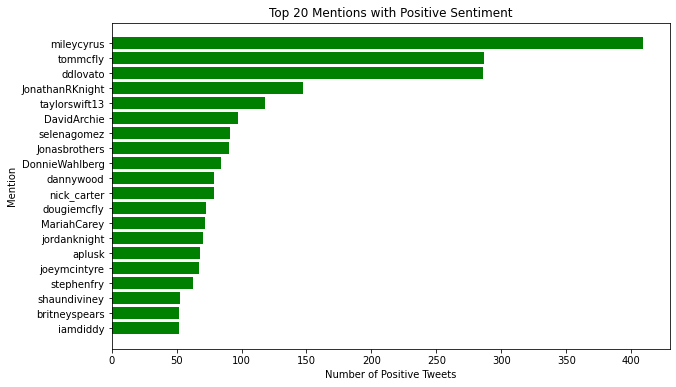

In [0]:
# Sort by positive count and select top 20 mentions
top_20_positive_mentions = mention_sentiment_counts_total.orderBy("positive_count", ascending=False).limit(20)

# Plot bar chart for top 20 mentions with positive sentiment
top_20_positive_mentions_pd = top_20_positive_mentions.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_20_positive_mentions_pd["mention"], top_20_positive_mentions_pd["positive_count"], color='green')
plt.xlabel("Number of Positive Tweets")
plt.ylabel("Mention")
plt.title("Top 20 Mentions with Positive Sentiment")
plt.gca().invert_yaxis()
plt.show()

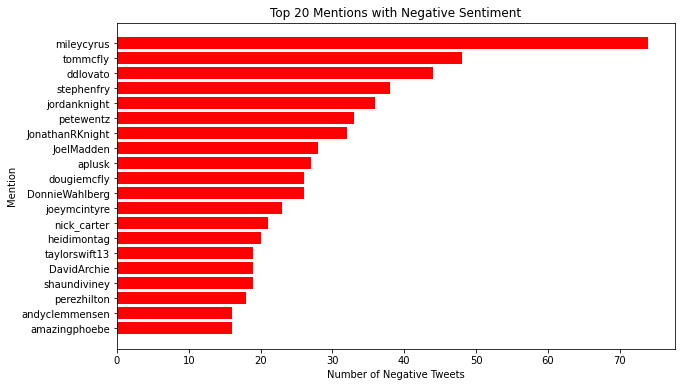

In [0]:
# Sort by negative count and select top 20 mentions
top_20_negative_mentions = mention_sentiment_counts.orderBy("negative_count", ascending=False).limit(20)

# Plot bar chart for top 20 mentions with negative sentiment
top_20_negative_mentions_pd = top_20_negative_mentions.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_20_negative_mentions_pd["mention"], top_20_negative_mentions_pd["negative_count"], color='red')
plt.xlabel("Number of Negative Tweets")
plt.ylabel("Mention")
plt.title("Top 20 Mentions with Negative Sentiment")
plt.gca().invert_yaxis()
plt.show()

## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:



# Get the StreamingQueryManager
streaming_query_manager = spark.streams

# Get a list of all active streams
active_streams = streaming_query_manager.active
print(active_streams)

[]


In [0]:
stop_all_streams()

Out[10]: False

In [0]:
START_TIME = time.time()
print(START_TIME)

1715483628.5924628


In [0]:
%python
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()
print(END_TIME)

1715483630.9385314


## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

##SPILL

In [0]:
Google drive link: https://drive.google.com/drive/folders/1ekxDD5pSU3IX_0r3wxvm6kLDa7_bN9mJ

In [0]:
1)Spill: Observation: Based on the data collected from the Spark UI, disk usage is minimal, with only 1301.9 KiB used out of a possible 463.9 GiB, which constitutes 0% utilization. Additionally, there is no significant spillage of data to disk, as evidenced by the storage metrics in the RDDs, where all cached partitions are kept entirely in memory. 
Analysis: The minimal disk spillage indicates that the application's memory allocation is more than sufficient to handle the current data and computational load without resorting to disk storage, which can severely slow down performance. 
Optimization Status: Well-optimized. Memory management strategies currently in place are effectively preventing memory spillage to disk. 


##SKEW

In [0]:
Observation: The reported numbers from the stages (Active Stages: 1, Pending Stages: 1, Completed Stages: 58, Skipped Stages: 40) do not provide direct evidence of skew. However, the significant number of skipped stages could suggest some form of conditional execution or optimization that could bypass certain computations.
 Analysis: Potential for skew could be further investigated by examining detailed task execution times within stages that show large variances.
 Optimization Status: Requires further analysis to determine if skew is present and affecting performance. Detailed monitoring of task execution times is recommended. 


##SHUFFLE

In [0]:
3. Shuffle: 
Observation: Specific tasks like silverst_df.count() and a SQL function demonstrated shuffle activities involving modest amounts of data transfer (832.5 KiB shuffle read and 1021.4 KiB shuffle write). 
Analysis: While the shuffle sizes are not exceptionally high, they signify a level of network I/O that could become a bottleneck as data volumes scale. This is especially relevant for operations that inherently require data redistribution. 
Optimization Status: Moderately optimized. Strategies to reduce shuffle, such as better partitioning or combining operations to minimize data redistribution, could further enhance performance.


## STORAGE

In [0]:
Observation: Extremely low disk usage for both data storage and metadata operations suggests that data is primarily handled in-memory, with effective use of cache mechanisms (53% cache hit ratio).
 Analysis: The current storage format and operations are efficient, given the very low percentage of disk usage and no evidence of large file handling inefficiencies. 
Optimization Status: Well-optimized in terms of storage. Future work could focus on improving the cache hit ratio to reduce reliance on external data sources even further. 


##SERIALIZATION

In [0]:
5. Serialization: 
Observation: The application shows efficient serialization practices with only a minimal portion of the available storage memory being utilized and minimal garbage collection overhead (6 seconds in a total of 2.2 hours of task time). 
Analysis: The data suggests that serialization overhead is not a limiting factor in the current setup, likely due to efficient memory management and possibly effective use of serialization libraries. 
Optimization Status: Well-optimized. Continued monitoring is advisable to ensure that serialization remains efficient as data structures and volumes change.


### ENTER YOUR MARKDOWN HERE